# 05 – Métodos de Clasificación

Este notebook tiene como objetivo aplicar **métodos de clasificación supervisada** usando la **Capa Oro Horaria** de datos meteorológicos.

**Tareas principales:**
- Crear variable objetivo para **viento fuerte** (`FF > 20 km/h`)
- Crear variable objetivo estimada para **lluvia** (`HUM > 95%` y `PNM < 1010 hPa`)
- Entrenar modelos supervisados: **Árbol de Decisión** y **KNN**
- Evaluar con matriz de confusión, F1-score y curvas ROC/AUC
- Analizar resultados y obtener conclusiones

In [20]:
# 1. Importar librerías
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, f1_score
import warnings

# Deshabilitar warnings futuros
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

print("Importación de librerías completada.")

Importación de librerías completada.


In [3]:
# 2. Cargar el dataset horario de Capa Oro
archivo_oro_horario = "../data/oro/misiones_oro_horario.csv"

df = pd.read_csv(archivo_oro_horario, parse_dates=['FECHA_HORA'])
print("Dataset cargado, filas:", len(df))
df.head()

Dataset cargado, filas: 20145


,NOMBRE,FECHA_HORA,FECHA,HORA,TEMP,HUM,PNM,DD,FF,estacion_archivo,DELTA_TEMP,DELTA_HUM,DELTA_PNM
0,IGUAZU AERO,2024-06-01 00:00:00,2024-06-01,0,13.8,91.0,1019.6,90.0,7.0,20240601.0,NaN,NaN,NaN
1,IGUAZU AERO,2024-06-01 01:00:00,2024-06-01,1,13.4,92.0,1019.5,90.0,7.0,20240601.0,-0.4,1.0,-0.1
2,IGUAZU AERO,2024-06-01 02:00:00,2024-06-01,2,13.0,94.0,1019.0,90.0,11.0,20240601.0,-0.4,2.0,-0.5
3,IGUAZU AERO,2024-06-01 03:00:00,2024-06-01,3,12.8,94.0,1018.3,90.0,9.0,20240601.0,-0.2,0.0,-0.7
4,IGUAZU AERO,2024-06-01 04:00:00,2024-06-01,4,12.4,94.0,1018.3,90.0,7.0,20240601.0,-0.4,0.0,0.0


In [4]:
# 3. Crear variables objetivo
df['EVENTO_VIENTO_FUERTE'] = (df['FF'] > 20).astype(int)
df['EVENTO_LLUVIA'] = ((df['HUM'] > 95) & (df['PNM'] < 1010)).astype(int)

print("Eventos de viento fuerte:", df['EVENTO_VIENTO_FUERTE'].sum())
print("Eventos de lluvia estimada:", df['EVENTO_LLUVIA'].sum())
df[['FECHA_HORA', 'FF', 'HUM', 'PNM', 'EVENTO_VIENTO_FUERTE', 'EVENTO_LLUVIA']].head(10)

Eventos de viento fuerte: 547
Eventos de lluvia estimada: 441


,FECHA_HORA,FF,HUM,PNM,EVENTO_VIENTO_FUERTE,EVENTO_LLUVIA
0,2024-06-01 00:00:00,7.0,91.0,1019.6,0,0
1,2024-06-01 01:00:00,7.0,92.0,1019.5,0,0
2,2024-06-01 02:00:00,11.0,94.0,1019.0,0,0
3,2024-06-01 03:00:00,9.0,94.0,1018.3,0,0
4,2024-06-01 04:00:00,7.0,94.0,1018.3,0,0
5,2024-06-01 05:00:00,4.0,94.0,1018.7,0,0
6,2024-06-01 06:00:00,4.0,95.0,1019.1,0,0
7,2024-06-01 07:00:00,6.0,94.0,1020.5,0,0
8,2024-06-01 08:00:00,4.0,91.0,1021.3,0,0
9,2024-06-01 09:00:00,17.0,86.0,1021.4,0,0


In [6]:
# 4. Selección de variables predictoras
X = df[['TEMP', 'HUM', 'PNM', 'FF', 'DD']]
y_viento = df['EVENTO_VIENTO_FUERTE']
y_lluvia = df['EVENTO_LLUVIA']

# Dividir en train/test
X_train, X_test, yv_train, yv_test = train_test_split(X, y_viento, test_size=0.3, random_state=42, stratify=y_viento)
_, _, yl_train, yl_test = train_test_split(X, y_lluvia, test_size=0.3, random_state=42, stratify=y_lluvia)

print("División en traint/test realizada correctamente.")

# Escalado para KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Escalado para KNN realizado correctamente.")


División en traint/test realizada correctamente.
Escalado para KNN realizado correctamente.


## 5. Entrenamiento y evaluación – Árbol de Decisión

In [7]:
# Árbol para viento fuerte
tree_viento = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_viento.fit(X_train, yv_train)

# Predicciones
yv_pred = tree_viento.predict(X_test)
print("\nMatriz de confusión – Viento Fuerte")
print(confusion_matrix(yv_test, yv_pred))
print(classification_report(yv_test, yv_pred))


Matriz de confusión – Viento Fuerte
[[5880    0]
 [   0  164]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5880
           1       1.00      1.00      1.00       164

    accuracy                           1.00      6044
   macro avg       1.00      1.00      1.00      6044
weighted avg       1.00      1.00      1.00      6044



In [8]:
# Árbol para lluvia
tree_lluvia = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_lluvia.fit(X_train, yl_train)

yl_pred = tree_lluvia.predict(X_test)
print("\nMatriz de confusión – Lluvia Estimada")
print(confusion_matrix(yl_test, yl_pred))
print(classification_report(yl_test, yl_pred))


Matriz de confusión – Lluvia Estimada
[[5909    3]
 [ 132    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5912
           1       0.00      0.00      0.00       132

    accuracy                           0.98      6044
   macro avg       0.49      0.50      0.49      6044
weighted avg       0.96      0.98      0.97      6044



## 6. Entrenamiento y evaluación – KNN

In [9]:
knn_viento = KNeighborsClassifier(n_neighbors=5)
knn_viento.fit(X_train_scaled, yv_train)

yv_pred_knn = knn_viento.predict(X_test_scaled)
print("\nMatriz de confusión – KNN Viento Fuerte")
print(confusion_matrix(yv_test, yv_pred_knn))
print(classification_report(yv_test, yv_pred_knn))


Matriz de confusión – KNN Viento Fuerte
[[5880    0]
 [  24  140]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5880
           1       1.00      0.85      0.92       164

    accuracy                           1.00      6044
   macro avg       1.00      0.93      0.96      6044
weighted avg       1.00      1.00      1.00      6044



In [10]:
knn_lluvia = KNeighborsClassifier(n_neighbors=5)
knn_lluvia.fit(X_train_scaled, yl_train)

yl_pred_knn = knn_lluvia.predict(X_test_scaled)
print("\nMatriz de confusión – KNN Lluvia Estimada")
print(confusion_matrix(yl_test, yl_pred_knn))
print(classification_report(yl_test, yl_pred_knn))


Matriz de confusión – KNN Lluvia Estimada
[[5910    2]
 [ 132    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5912
           1       0.00      0.00      0.00       132

    accuracy                           0.98      6044
   macro avg       0.49      0.50      0.49      6044
weighted avg       0.96      0.98      0.97      6044



## 7. Curvas ROC / AUC para Árbol de Decisión
Esto nos permitirá evaluar la capacidad de discriminación de los modelos.

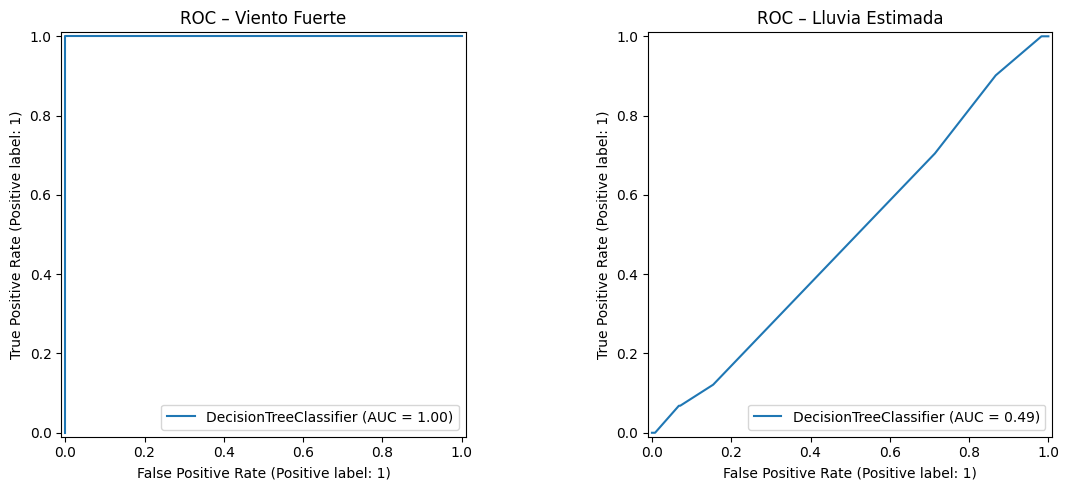

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ROC para viento fuerte
RocCurveDisplay.from_estimator(tree_viento, X_test, yv_test, ax=axes[0])
axes[0].set_title('ROC – Viento Fuerte')

# ROC para lluvia estimada
RocCurveDisplay.from_estimator(tree_lluvia, X_test, yl_test, ax=axes[1])
axes[1].set_title('ROC – Lluvia Estimada')

plt.tight_layout()
plt.show()

# 8. Interpretación: Importancia de Variables en Árbol de Decisión

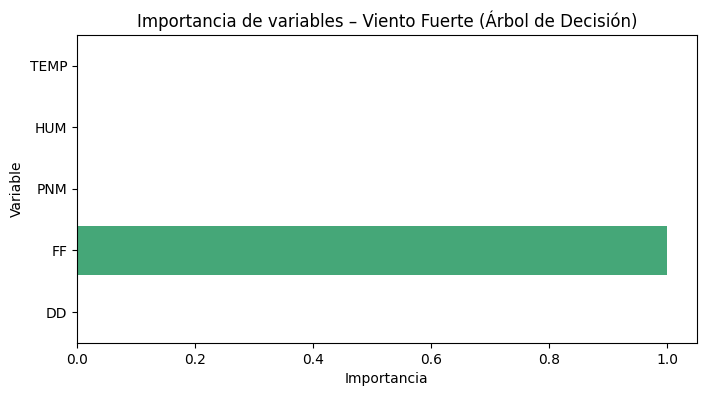


🔹 Importancia de variables (viento fuerte):
TEMP: 0.000
HUM: 0.000
PNM: 0.000
FF: 1.000
DD: 0.000


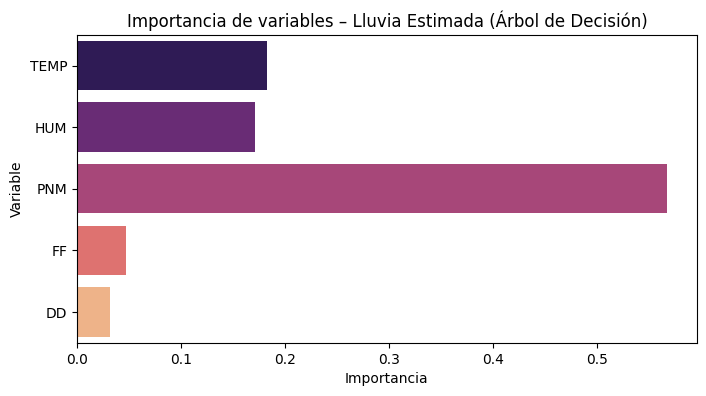


🔹 Importancia de variables (lluvia estimada):
TEMP: 0.183
HUM: 0.171
PNM: 0.567
FF: 0.047
DD: 0.032


In [17]:
# Importancia de variables para viento fuerte
importancias_viento = tree_viento.feature_importances_
variables = X.columns

plt.figure(figsize=(8,4))
sns.barplot(x=importancias_viento, y=variables, palette="viridis")
plt.title("Importancia de variables – Viento Fuerte (Árbol de Decisión)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

# Imprimir importancia en tabla
print("\n🔹 Importancia de variables (viento fuerte):")
for var, imp in zip(variables, importancias_viento):
    print(f"{var}: {imp:.3f}")

# Importancia de variables para lluvia estimada
importancias_lluvia = tree_lluvia.feature_importances_

plt.figure(figsize=(8,4))
sns.barplot(x=importancias_lluvia, y=variables, palette="magma")
plt.title("Importancia de variables – Lluvia Estimada (Árbol de Decisión)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

print("\n🔹 Importancia de variables (lluvia estimada):")
for var, imp in zip(variables, importancias_lluvia):
    print(f"{var}: {imp:.3f}")

In [21]:
ORO_DIR = Path("../data/oro")

# Exportar predicciones sobre el conjunto de prueba
predicciones = pd.DataFrame({
    "FECHA_HORA": df.loc[X_test.index, "FECHA_HORA"],
    "ESTACION": df.loc[X_test.index, "NOMBRE"],
    "Viento_Fuerte_Real": yv_test.values,
    "Viento_Fuerte_Pred_Arbol": yv_pred,
    "Viento_Fuerte_Pred_KNN": yv_pred_knn,
    "Lluvia_Real": yl_test.values,
    "Lluvia_Pred_Arbol": yl_pred,
    "Lluvia_Pred_KNN": yl_pred_knn
})

archivo_predicciones = ORO_DIR / "predicciones_test.csv"
predicciones.to_csv(archivo_predicciones, index=False)
print(f"Predicciones exportadas a: {archivo_predicciones}")

# Exportar importancia de variables
df_importancia = pd.DataFrame({
    "Variable": variables,
    "Importancia_Viento": importancias_viento,
    "Importancia_Lluvia": importancias_lluvia
})

archivo_importancias = ORO_DIR / "importancia_variables.csv"
df_importancia.to_csv(archivo_importancias, index=False)
print(f"Importancia de variables exportada a: {archivo_importancias}")

# Resumen de métricas
metricas = pd.DataFrame([
    ["Árbol - Viento Fuerte", accuracy_score(yv_test, yv_pred), f1_score(yv_test, yv_pred)],
    ["KNN - Viento Fuerte", accuracy_score(yv_test, yv_pred_knn), f1_score(yv_test, yv_pred_knn)],
    ["Árbol - Lluvia Estimada", accuracy_score(yl_test, yl_pred), f1_score(yl_test, yl_pred)],
    ["KNN - Lluvia Estimada", accuracy_score(yl_test, yl_pred_knn), f1_score(yl_test, yl_pred_knn)]
], columns=["Modelo", "Accuracy", "F1_Score"])

archivo_metricas = ORO_DIR / "metricas_modelos.csv"
metricas.to_csv(archivo_metricas, index=False)
print(f"Métricas exportadas a: {archivo_metricas}")

print("\nResumen de métricas:")
print(metricas)

Predicciones exportadas a: ../data/oro/predicciones_test.csv
Importancia de variables exportada a: ../data/oro/importancia_variables.csv
Métricas exportadas a: ../data/oro/metricas_modelos.csv

Resumen de métricas:
                    Modelo  Accuracy  F1_Score
0    Árbol - Viento Fuerte  1.000000  1.000000
1      KNN - Viento Fuerte  0.996029  0.921053
2  Árbol - Lluvia Estimada  0.977664  0.000000
3    KNN - Lluvia Estimada  0.977829  0.000000


## 8. Conclusiones
- Se entrenaron modelos supervisados para **viento fuerte** y **lluvia estimada**.
- Se compararon **Árboles de Decisión** y **KNN**.
- Se calcularon **matrices de confusión**, **F1-score** y **curvas ROC/AUC**.
- Este análisis sirve como base para **la Capa Oro** y para aplicar **minería de datos y clasificación supervisada** sobre datos meteorológicos.